## Vision Porject

In [3]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio


## Quick Look at the Data
There's some data provided in the `test_dataset` folder. 

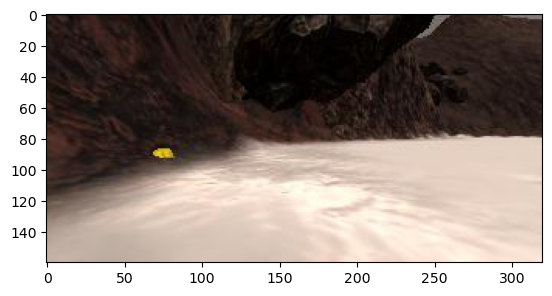

In [7]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images. 

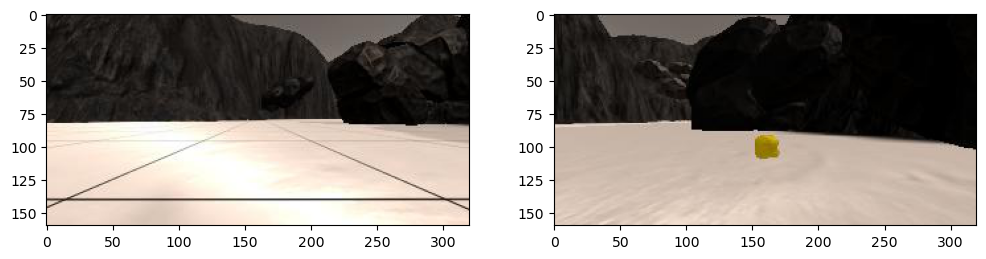

In [16]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

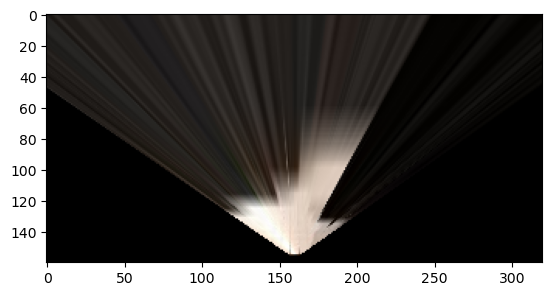

In [17]:
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


dst = 3
bottom_offset = 5
source = np.float32([[14, 140],
                    [300, 140],
                    [200, 95],
                    [120, 95]])
destination = np.float32([[image.shape[1] / 2 - dst, image.shape[0] - bottom_offset],
                        [image.shape[1] / 2 + dst, image.shape[0] - bottom_offset],
                        [image.shape[1] / 2 + dst, image.shape[0] - 2*dst - bottom_offset],
                        [image.shape[1] / 2 - dst, image.shape[0] - 2*dst - bottom_offset]])

warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)

## Color Thresholding


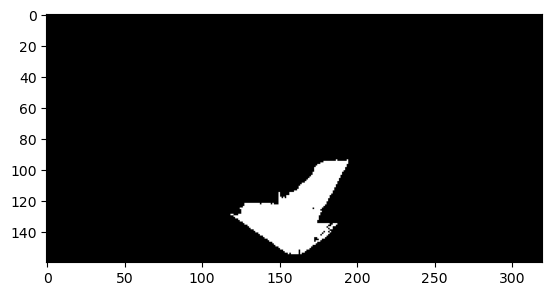

In [22]:
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')

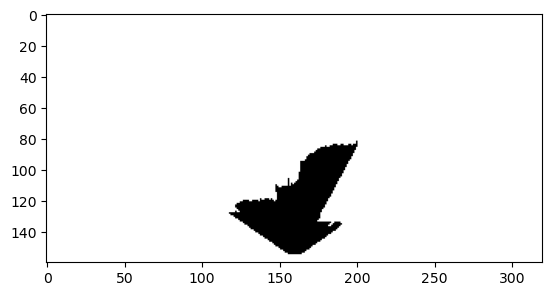

In [27]:
def obs_thresh(img, rgb_thresh=(130, 130, 130)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    below_thresh = (img[:,:,0] < rgb_thresh[0]) \
                & (img[:,:,1] < rgb_thresh[1]) \
                & (img[:,:,2] < rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[below_thresh] = 1
    # Return the binary image
    return color_select

obstacles = obs_thresh(warped)
plt.imshow(obstacles, cmap='gray')


## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

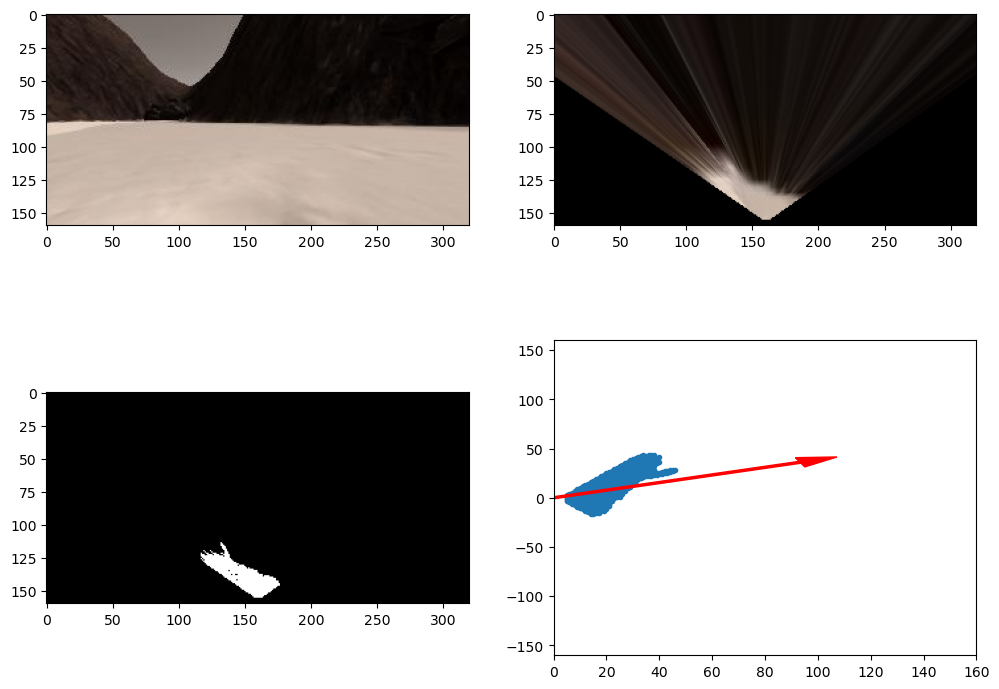

In [31]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle)
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles
# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))                    
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale):
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = nav_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))

plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)

fig.savefig('../misc/analys.jpg')

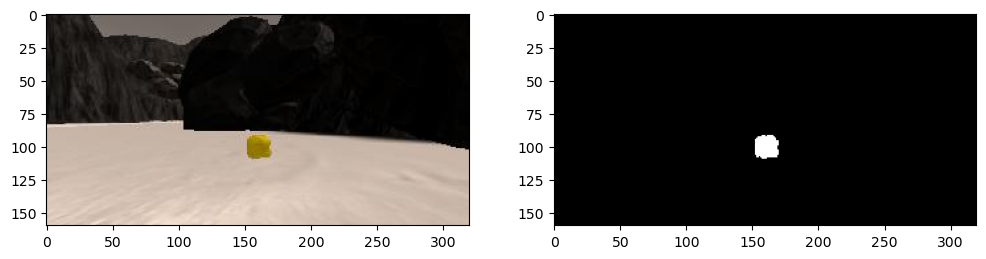

In [32]:
def rock_thresh(img):
    # Convert BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV, 3)
    
    # Define range of yellow colors in HSV
    lower_yellow = np.array([20, 150, 100], dtype='uint8')
    upper_yellow = np.array([50, 255, 255], dtype='uint8')
    
    # Threshold the HSV image to get only yellow colors
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    return mask 

rock_map = rock_thresh(rock_img)
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(rock_img)
plt.subplot(122)
plt.imshow(rock_map, cmap='gray')

fig.savefig('../misc/rok_threshed.jpg')

## Read in saved data and ground truth map of the world


In [35]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


## Write a function to process stored images

In [60]:
# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])
    

    # Perform perception steps to update Rover()
    # TODO:
    # NOTE: camera image is coming to you in Rover.img
    # 1) Define source and destination points for perspective transform
    dst = 3
    bottom_offset = 5
    source = np.float32([[14, 140],
                         [300, 140],
                         [200, 95],
                         [120, 95]])
    destination = np.float32([[image.shape[1] / 2 - dst, image.shape[0] - bottom_offset],
                              [image.shape[1] / 2 + dst, image.shape[0] - bottom_offset],
                              [image.shape[1] / 2 + dst, image.shape[0] - 2*dst - bottom_offset],
                              [image.shape[1] / 2 - dst, image.shape[0] - 2*dst - bottom_offset]])

    # 2) Apply perspective transform
    warped = perspect_transform(image, source, destination)
    
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    threshed = nav_thresh(warped, (160, 160, 160))   
    obstacles = obs_thresh(warped, (130, 130, 130))     
    rocks = rock_thresh(warped)
    
    # 4) Convert thresholded image pixel values to rover-centric coords
    roverx, rovery = rover_coords(threshed)
    rocksx, rocksy = rover_coords(rocks)
    obstaclesx, obstaclesy = rover_coords(obstacles)
    
    # 5) Convert rover-centric pixel values to world coords
    scale = 9
    try:
        xpos, ypos = data.xpos[data.count], data.ypos[data.count]
        yaw = data.yaw[data.count]
    except IndexError:
        xpos, ypos = data.xpos[data.count-1], data.ypos[data.count-1]
        yaw = data.yaw[data.count-1]
        wm = Rover.worldmap
        rover_wx, rover_wy = pix_to_world(roverx, rovery, Rover.pos[0], Rover.pos[1], Rover.yaw, wm.shape[0], scale)
        obs_wx, obs_wy = pix_to_world(obstaclesx, obstaclesy,Rover.pos[0],  Rover.pos[1], Rover.yaw, wm.shape[0], scale)
        rock_wx, rock_wy = pix_to_world(rocksx, rocksy,Rover.pos[0], Rover.pos[1], Rover.yaw, wm.shape[0], scale)
    
    # 6) Update worldmap (to be displayed on right side of screen)
        data.worldmap[obs_wy, obs_wx, 0] = 200
        #Rover.worldmap[rover_wy, rover_wx, 0] = 0
        data.worldmap[rock_wy, rock_wx, 1] = 255
        data.worldmap[rover_wy, rover_wx, 2] =255
    
    # 7) Make a mosaic image, below is some example code
    # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
    # Next you can populate regions of the image with various output
    # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

    # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, source, destination)
    # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

    # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
    # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)

    # Then putting some text over the image
    cv2.putText(output_image,"Navigable: Blue/Pink; Obstacle: Red; Sample Rock: Yellow", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)

    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

## Make a video from processed image data
  

In [61]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))